In [2]:
# The output of this cell should be committed to the repo such that the styles are applied after
# opening the notebook

from IPython.core.display import HTML

with open("rise.css", "r") as f:
    styles = f.read()
HTML(f'<style>{styles}</style>')

In [3]:
import numpy as np
import itertools as it
from tqdm import tqdm

import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
import pandas as pd

import ipywidgets as widgets

from exercise_tools import evaluate, get_kdd_data, get_house_prices_data, create_distributions, contamination, \
perform_rkde_experiment

from ipywidgets import interact

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.datasets import fetch_openml

from vae import VAE, build_decoder_mnist, build_encoder_minst, build_contaminated_minst

from tensorflow import keras

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)


<img src="aai_presentation_first_slide.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Anomaly Detection</div>

# Anomaly Detection via Density Estimation
**Idea:** Estimate the density of $F_0$. Areas of low density are anomalous.
- Often $p$ is too small to estimate complete mixture model.
- Takes into account that $F_1$ might not be well defined.
- Estimation procedure needs to be robust against contamination if no clean training data is available.

## Kernel Density Estimation
- Non-parametric method
- Can represent almost arbitrarily shaped densities
- Each training point "spreads" a fraction of the probability mass as specified by the kernel function


---
<img src="images/kernels.png" style="margin:0px 100px" width="600" align="right">

**Definition:**
- $K: \mathbb{R} \to \mathbb{R}$ kernel function
    - $K(r) \geq 0$ for all $r\in \mathbb{R}$
	- $\int_{-\infty}^{\infty} K(r) dr = 1$
- $h > 0$ bandwidth
- Bandwidth is the most crucial parameter
---






---
**Definition:**
Let $D = \{x_1,\ldots,x_N\}\subset \mathbb{R}^p$. The KDE with kernel $K$ and bandwidth $h$ is
$KDE_h(x, D) = \frac{1}{N}\sum_{i=1}^N \frac{1}{h^p}K\left(\frac{|x-x_i|}{h}\right)$

---
<table style="width:60%">
    <tr>
        <td width="20%" style="background-color:#FFFFFF;"><img src="images/bandwidth.png" width="100"></td>
        <td style="background-color:#FFFFFF;"><img src="images/1dkde.png"></td>
    </tr>
    <tr>
        <td style="background-color:#FFFFFF;" colspan="2"><center>Effect of bandwidth and kernel</center></td>
    </tr>
</table>

### Exercise
Play with the parameters!

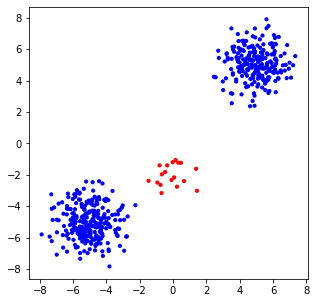

In [34]:
dists = create_distributions(dim=2, dim_irrelevant=0)
contamination_model = contamination(nominal=dists['Double Blob'], anomaly=dists['Blob'], p=0.05)

sample_train = dists['Double Blob'].sample(500)
X_train = sample_train[-1]
y_train = sample_train[0]

sample_test = contamination_model.sample(500)
X_test = sample_test[-1]
y_test = sample_test[0]

plt.scatter(X_test[:,0], X_test[:,1], c=['blue' if target == 0 else 'red' for target in y_test], s=10)
plt.show()

In [35]:
# Helper function
def visualize_kde(kernel, bandwidth, X_train, y_train):
    fig, axis = plt.subplots(figsize=(5, 5))
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(X_train)

    lin = np.linspace(-10, 10, 50)
    grid_points = list(it.product(lin, lin))
    ys, xs = np.meshgrid(lin, lin)
    # The score function of sklearn returns log-densities
    scores = np.exp(kde.score_samples(grid_points)).reshape(50, 50)
    colormesh = axis.contourf(xs, ys, scores)
    fig.colorbar(colormesh)
    axis.set_title('Density Conturs (Bandwidth={})'.format(bandwidth))
    axis.set_aspect('equal')
    color = ['blue' if i ==0 else 'red' for i in y_train]
    plt.scatter(X_train[:, 0], X_train[:, 1], c=color)
    plt.show()

# Choose KDE Parameters

In [36]:
ker = None
bdw = None
@interact(
    kernel=['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'],
    bandwidth=(.1, 10.)
)
def set_kde_params(kernel, bandwidth):
    global ker, bdw

    ker = kernel
    bdw = bandwidth

interactive(children=(Dropdown(description='kernel', options=('gaussian', 'tophat', 'epanechnikov', 'exponenti…

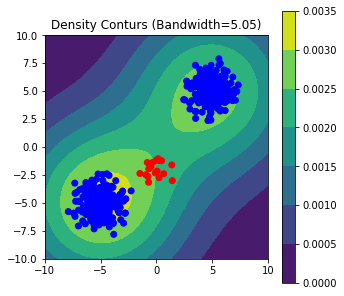

In [37]:
visualize_kde(ker, bdw, X_test, y_test)

## Bandwidth Selection
The bandwidth is the most important parameter of a KDE model. A wrongly adjusted value will lead to over- or
under-smoothing of the density curve.

A common methods to select a bandwidth is maximum log-likelyhood cross validation.
$$h_{\textrm{llcv}} = \arg\max_{h}\frac{1}{k}\sum_{i=1}^k\sum_{y\in D_i}\log\left(\frac{k}{N(k-1)}\sum_{x\in D_{-i}}K_h(x, y)\right)$$
where $D_{-i}$ is the data without the $i$th cross validation fold $D_i$.

# Exercises

ex no.1: Noisy sinusoidal

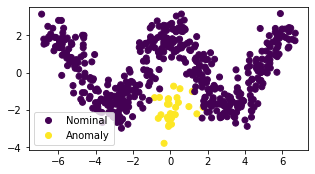

In [20]:
# Generate example
dists = create_distributions(dim=2)

distribution_with_anomalies = contamination(
    nominal=dists['Sinusoidal'],
    anomaly=dists['Blob'],
    p=0.05
)

# Train data
sample_train = dists['Sinusoidal'].sample(500)
X_train = sample_train[-1].numpy()

# Test data
sample_test = distribution_with_anomalies.sample(500)
X_test = sample_test[-1].numpy()
y_test = sample_test[0].numpy()

scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
handels, _ = scatter.legend_elements()
plt.legend(handels, ['Nominal', 'Anomaly'])
plt.gca().set_aspect('equal')
plt.show()

In [21]:
####################################################################################################################
# TODO: Define the search space for the kernel and the bandwidth
####################################################################################################################
param_space = {
    'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'], # Add available kernels
    'bandwidth': np.linspace(0.1, 10, 100), # Define Search space for bandwidth parameter
}

def hyperopt_by_score(X_train, param_space, cv=5):
    kde = KernelDensity()

    search = RandomizedSearchCV(
        estimator=kde,
        param_distributions=param_space,
        n_iter=100,
        cv=cv,
        scoring=None # use estimators internal scoring function, i.e. the log-probability of the validation set for KDE
    )

    search.fit(X_train)
    return search.best_params_, search.best_estimator_

Run below code to perform hyperparameter optimization.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [-515.04752176 -533.82651782 -481.81845329 -651.16834302 -633.23625032
 -567.65804583 -492.13440461 -636.86744536 -487.76849094 -557.90390974
 -630.51708999 -453.42659493 -521.97434926 -531.86516655 -512.58645801
 -506.40723614 -631.53656899 -573.29354506 -623.6861896  -494.20341918
 -442.40164581 -453.10330406 -394.34004481 -611.44834619          -inf
 -505.57998475 -645.3629786  -531.18380644 -600.80826114 -508.88140308
 -558.96823013 -631.79693629 -489.45021571 -450.058067   -524.86563123
 -657.21444112 -613.52752478 -513.2466979  -447.25545661 -541.14131331
 -674.5825439  -573.81149033 -422.55045677 -502.70270633 -677.9581566
 -391.45408485 -523.16205121 -679.62525555 -616.25212855 -524.99852538
 -533.3292087  -438.11257361 -532.77803962 -681.27884209 -469.14874483
 -549.76545489 -580.09903727 -476.63962282

Best parameters:
kernel: epanechnikov
bandwidth: 1.0


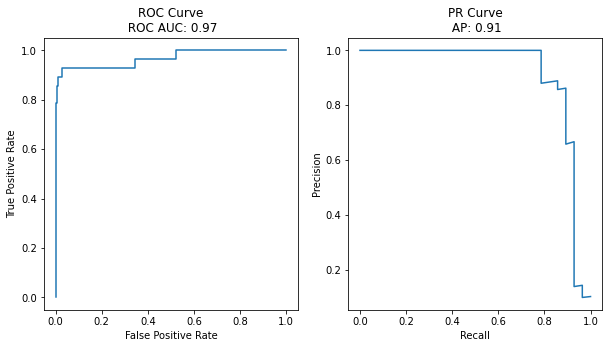

In [22]:
params, kde = hyperopt_by_score(X_train, param_space)

print('Best parameters:')
for key in params:
    print('{}: {}'.format(key, params[key]))

test_scores = -kde.score_samples(X_test)
test_scores = np.where(test_scores == np.inf, np.max(test_scores[np.isfinite(test_scores)])+1, test_scores)

curves = evaluate(y_test, test_scores)

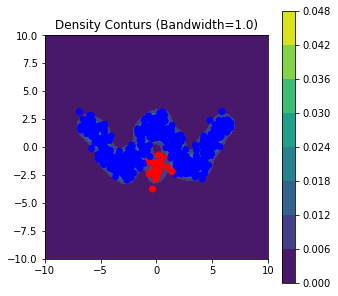

In [23]:
visualize_kde(params['kernel'], params['bandwidth'], X_test, y_test)

### Exercise: Isolate anomalies in house prices

You are a company resposible to estimate house prices around Ames, Iowa, specifically around college area. But there is a problem: houses from a nearby area, 'Veenker', are often included in your dataset. You want to build an anomaly detection algorithm that filters one by one every point that comes from the wrong neighborhood. You have been able to isolate an X_train dataset which, you are sure, contains only houses from College area. Following the previous example, test your ability to isolate anomalies in new incoming data (X_test) with KDE.

Advanced exercise:
What happens if the contamination comes from other areas? You can choose among the following names:

OldTown, Veenker, Edwards, MeadowV, Somerst, NPkVill, BrDale, Gilbert, NridgHt, Sawyer, Blmngtn, Blueste

In [24]:
X_train, X_test, y_test = get_house_prices_data(neighborhood = 'CollgCr', anomaly_neighborhood='Veenker')
X_train

,LotArea,SalePrice,OverallCond
0,10000,240000,5
1,9100,178000,5
2,10970,147000,6
3,9236,217000,5
4,12803,221000,5
...,...,...,...
115,8924,188000,5
116,14006,192500,5
117,10667,212000,6
118,8760,239799,5


In [12]:
# Total data
train_test_data = X_train.append(X_test, ignore_index=True)
y_total = [0] * len(X_train) + y_test

fig = px.scatter_3d(train_test_data, x='LotArea', y='OverallCond', z='SalePrice', color=y_total)

fig.show()

### Solution

When data are highly in-homogeneous, like in this case, it is often beneficial to rescale them before applying any anomaly detection or clustering technique.

In [13]:
scaler = MinMaxScaler()
X_train_rescaled = scaler.fit_transform(X_train)

In [14]:
param_space = {
    'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'], # Add available kernels
    'bandwidth': np.linspace(0.1, 10, 100), # Define Search space for bandwidth parameter
}
params, kde = hyperopt_by_score(X_train_rescaled, param_space)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning:

One or more of the test scores are non-finite: [-214.1049886   -65.72340928 -175.50471145   15.29500678 -117.57801145
 -154.2059124  -179.45090448 -129.66348117 -164.15445644 -224.65351664
 -195.70898463 -206.77936872  -71.31118409 -225.97822409 -145.80238763
 -132.93068779  -13.17728479 -154.45277808 -171.38387172 -175.29278063
  -98.06404666 -157.9840137  -164.83619188 -124.84800341 -119.345055
  -38.00550882 -158.59905914 -160.39550546 -186.74828407 -190.28904036
  -54.43885529 -141.60799722          -inf -181.26831615    0.8036419
  -24.59284267 -105.28952933 -141.05341395 -147.90496508 -137.70397282
 -132.94069057  -79.77924298 -178.48444701 -192.28633172 -164.57467852
 -153.80235395 -105.16881811 -235.84153183  -37.85878159 -156.59277741
 -182.15127515  -24.83541999 -141.51898606 -165.70788427 -167.91534137
 -166.8974606  -144.25394085 -209.34133189 

Best parameters:
kernel: linear
bandwidth: 0.5


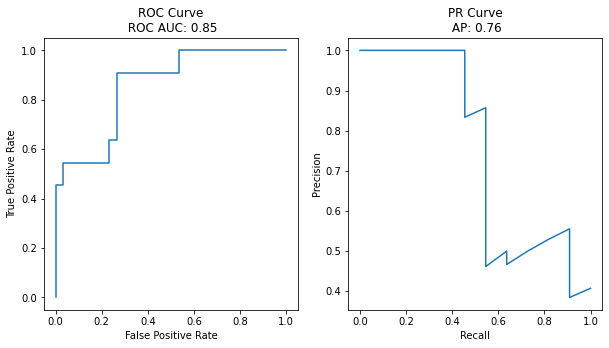

In [15]:
print('Best parameters:')
for key in params:
    print('{}: {}'.format(key, params[key]))

X_test_rescaled = scaler.transform(X_test)
test_scores = -kde.score_samples(X_test_rescaled)
test_scores = np.where(test_scores == np.inf, np.max(test_scores[np.isfinite(test_scores)])+1, test_scores)
curves = evaluate(y_test, test_scores)

## The Curse of Dimensionality
The flexibility of KDE comes at a price. The dependency on the dimensionality of the data is quite unfavorable.

---
*Theorem* [Stone, 1982]
Any estimator that is consistent$^*$ with the class of all $k$-fold differentiable pdfs over $\mathbb{R}^d$ has a
convergence rate of at most

$$
\frac{1}{n^{\frac{k}{2k+d}}}
$$


---

$^*$Consistency = for all pdfs $p$ in the class: $\lim_{n\to\infty}|KDE_h(x, D) - p(x)|_\infty = 0$ with probability $1$.

# Exercise
- The very slow convergence in high dimensions does not necessarily mean that we will see bad results in   high dimensional anomaly detection with KDE.
- Especially if the anomalies are very outlying.
- However, in cases where contours of the nominal distribution is non-convex we can run into problems.

We take a look at a higher dimensional version of out previous data set.

In [16]:
dists = create_distributions(dim=3)

distribution_with_anomalies = contamination(
    nominal=dists['Sinusoidal'],
    anomaly=dists['Blob'],
    p=.02
)

sample = distribution_with_anomalies.sample(500)

y = sample[0]
X = sample[-1]

In [17]:
fig = px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=y)
fig.show()

In [18]:
# Fit KDE on high dimensional examples 
rocs = []
auprs = []
bandwidths = []

param_space = {
        'kernel': ['gaussian'],
        'bandwidth': np.linspace(0.1, 100, 1000), # Define Search space for bandwidth parameter
    }

kdes = {}
dims = np.arange(2,16)
for d in tqdm(dims):
    # Generate d dimensional distributions
    dists = create_distributions(dim=d)

    distribution_with_anomalies = contamination(
        nominal=dists['Sinusoidal'],
        anomaly=dists['Blob'],
        p=.05
    )

    # Train on clean data
    sample_train = dists['Sinusoidal'].sample(500)
    X_train = sample_train[-1].numpy()
    # Test data
    sample_test = distribution_with_anomalies.sample(500)
    X_test = sample_test[-1].numpy()
    y_test = sample_test[0].numpy()

    # Optimize bandwidth
    params, kde = hyperopt_by_score(X_train, param_space)
    kdes[d] = (params, kde)
    
    bandwidths.append(params['bandwidth'])

    test_scores = -kde.score_samples(X_test)
    test_scores = np.where(test_scores == np.inf, np.max(test_scores[np.isfinite(test_scores)])+1, test_scores)

    rocs.append(roc_auc_score(y_test, test_scores))
    auprs.append(average_precision_score(y_test, test_scores))

    

100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


100%|██████████| 14/14 [00:01<00:00, 10.92it/s]


Crossection of the KDE at (0,...,0, x, y)


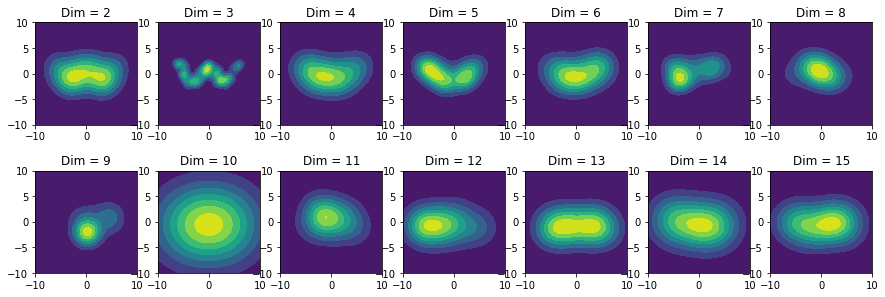

Evaluation with N((0,-2), .1) contamination


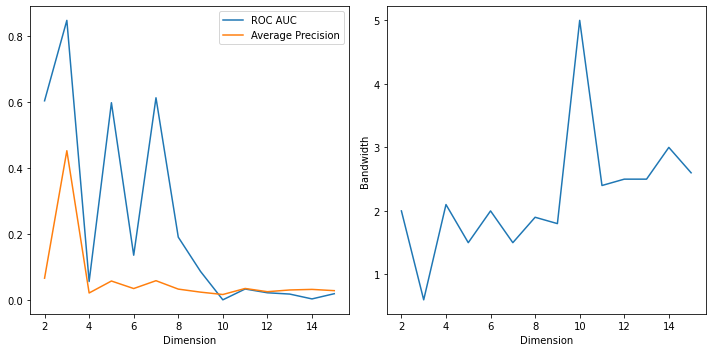

In [19]:
# Plot cross section of pdf 
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(15, 5))
for d, axis in tqdm(list(zip(kdes, axes.flatten()))):
    
    params, kde = kdes[d]

    lin = np.linspace(-10, 10, 50)
    grid_points = list(it.product(*([[0]]*(d-2)), lin, lin))
    ys, xs = np.meshgrid(lin, lin)
    # The score function of sklearn returns log-densities
    scores = np.exp(kde.score_samples(grid_points)).reshape(50, 50)
    colormesh = axis.contourf(xs, ys, scores)
    axis.set_title("Dim = {}".format(d))
    axis.set_aspect('equal')
    

# Plot evaluation
print('Crossection of the KDE at (0,...,0, x, y)')
plt.show()

_, axes = plt.subplots(ncols=2, figsize=(10, 5))
print('Evaluation with N((0,-2), .1) contamination')
axes[0].plot(dims, rocs)
axes[0].plot(dims, auprs)
axes[0].legend(labels=['ROC AUC', 'Average Precision'])
axes[0].set_xlabel("Dimension")
axes[1].plot(dims, bandwidths)
axes[1].set_xlabel("Dimension")
axes[1].set_ylabel("Bandwidth")
plt.tight_layout()
plt.show()

## Robustness
Another drawback of KDE in the context of anomaly detection is that it is not robust against contamination of the data

---
**Definition**
The *breakdown point* of an estimator is the smallest fraction of observations that need to be changed so that we can
move the estimate arbitrarily far away from the true value.

---

**Example**: The sample mean has a breakdown point of $0$. Indeed, for a sample of $x_1,\ldots, x_n$ we only need to
change a single value in order to move the sample mean in any way we want. That means that the breakdown point is
smaller than $\frac{1}{n}$ for every $n\in\mathbb{N}$.

## Robust Statistics
There are robust replacements for the sample mean:
- Median of means: Split the dataset into $S$ equally sized subsets $X_1,\ldots, X_S$ and compute
$\mathrm{median}(\overline{X_1},\ldots, \overline{X_S})$
- M-estimation: The mean in a normed vector space is the value that minimizes the squared distances
<center>
$\overline{X} = \min_{y}\sum_{x\in X}|x-y|^2$
</center>
M-estimation replaces the quadratic loss with a more robust loss function.

### Huber loss
Switch from quadratic to linear loss at prescribed threshold

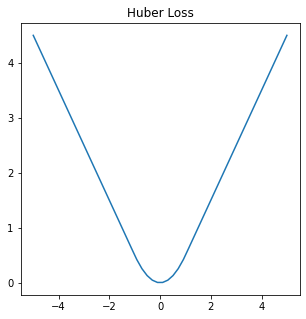

In [7]:
import numpy as np


def huber(error, threshold):
    test = (np.abs(error) <= threshold)
    return (test * (error**2)/2) + ((1-test)*threshold*(np.abs(error) - threshold/2))

x = np.linspace(-5, 5)
y = huber(x, 1)

plt.plot(x, y)
plt.gca().set_title("Huber Loss")
plt.show()

### Hampel loss
More complex loss function. Depends on 3 parameters 0 < a < b< r

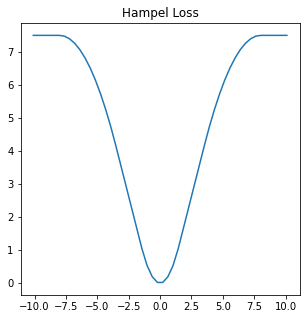

In [80]:
import numpy as np

def single_point_hampel(error, a, b, r):
    if abs(error) <= a:
        return error**2/2
    elif a < abs(error) <= b:
        return (1/2 *a**2 + a* (abs(error)-a))
    elif  b < abs(error) <= r:
        return a * (2*b-a+(abs(error)-b) * (1+ (r-abs(error))/(r-b)))/2
    else:
        return a*(b-a+r)/2

hampel = np.vectorize(single_point_hampel)

x = np.linspace(-10.1, 10.1)
y = hampel(x, a=1.5, b=3.5, r=8)

plt.plot(x, y)
plt.gca().set_title("Hampel Loss")
plt.show()

## KDE is a Mean

---

**Kernel as scalar product:**
<img src="images/kernels.png" align="right" width="400" style="margin: 150px 75px">

- Let $K$ be a radial monotonic$^\ast$ kernel over $\mathbb{R}^n$.
- For $x\in\mathbb{R}^n$ let $\phi_x = K(\cdot, x)$.
- Vector space over the linear span of $\{\phi_x \mid x\in\mathbb{R}^n\}$:
    - Pointwise addition and scalar multiplication.
- Define the scalar product $\langle \phi_x, \phi_y\rangle = K(x,y)$.
- Advantage: Scalar product is computable
- Call this the reproducing kernel Hilbert space (RKHS) of $K$.
- $\mathrm{KDE}_h(\cdot, D) = \frac{1}{N}\sum_{i=1}^N K_h(\cdot, x_i) = \frac{1}{N}\sum_{i=1}^N\phi_{x_i}$
    - where $K_h(x,y) = \frac{1}{h}K\left(\frac{|x-y|}{h}\right)$

---

$^*$All kernels that we have seen are radial and monotonic




# Exercise
We compare the performance of different approaches to recover the nominal distribution under contamination.
Here, we use code by [Humbert et al.](https://github.com/lminvielle/mom-kde) to replicate
the results in the referenced paper on median-of-mean KDE. More details on rKDE can instead be found in this paper by [Kim and Scott.](https://arxiv.org/abs/1107.3133#:~:text=We%20propose%20a%20method%20for,ideas%20from%20classical%20M%2Destimation.)

In [8]:
# =======================================================
#   Parameters
# =======================================================
algos = [
    'kde',
    'mom-kde', # Median-of-Means
    'rkde-huber', # robust KDE with huber loss
    'rkde-hampel', # robust KDE with hampel loss
]

dataset = 'house-prices'
dataset_options = {'neighborhood': 'CollgCr', 'anomaly_neighborhood': 'Edwards'}

outlierprop_range = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
kernel = 'cosine'

In [9]:
auc_scores = perform_rkde_experiment(
    algos,
    dataset,
    dataset_options,
    outlierprop_range,
    kernel,
)

Dataset:  house-prices



Outlier prop: 0.01 (1 / 10)
downsample outliers
Finding best bandwidth...
Algo:  kde
Algo:  mom-kde
Algo:  rkde-huber
Stop at 4 iterations
Stop at 2 iterations
Algo:  rkde-hampel
Stop at 4 iterations
Stop at 100 iterations

Outlier prop: 0.02 (2 / 10)
downsample outliers
Finding best bandwidth...
Algo:  kde
Algo:  mom-kde
Algo:  rkde-huber
Stop at 4 iterations
Stop at 2 iterations
Algo:  rkde-hampel
Stop at 4 iterations
Stop at 100 iterations

Outlier prop: 0.03 (3 / 10)
downsample outliers
Finding best bandwidth...
Algo:  kde
Algo:  mom-kde
Algo:  rkde-huber
Stop at 3 iterations
Stop at 2 iterations
Algo:  rkde-hampel
Stop at 3 iterations
Stop at 100 iterations

Outlier prop: 0.05 (4 / 10)
downsample outliers
Finding best bandwidth...
Algo:  kde
Algo:  mom-kde
Algo:  rkde-huber
Stop at 4 iterations
Stop at 3 iterations
Algo:  rkde-hampel
Stop at 4 iterations
Stop at 100 iterations

Outlier prop: 0.07 (5 / 10)
downsample outliers
Finding best bandwidth...
Algo:  kde
Algo:  mom-kde
Alg

Text(0.5, 1.0, 'Comparison of rKDE against contamination')

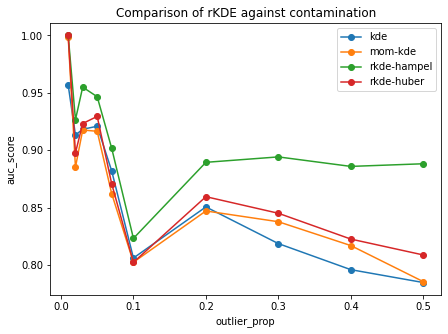

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))
for algo, algo_data in auc_scores.groupby('algo'):
    x = algo_data.groupby('outlier_prop').mean().index
    y = algo_data.groupby('outlier_prop').mean()['auc_anomaly']
    ax.plot(x, y, 'o-', label=algo)
plt.legend()
plt.xlabel('outlier_prop')
plt.ylabel('auc_score')
plt.title('Comparison of rKDE against contamination')

Try using different neighborhoods for contamination. Which robust KDE algorithm performs better overall? Choose among the following options:

OldTown, Veenker, Edwards, MeadowV, Somerst, NPkVill, BrDale, Gilbert, NridgHt, Sawyer, Blmngtn, Blueste

You can also change the kernel type: gaussian, tophat, epechenikov, exponential, linear or cosine, 

# Summary
- Kernel density estimation is a non-parametric method to estimate a pdf from a sample.
- Bandwidth is the most important parameter.
- Converges to the true pdf if $n\to\infty$.
    - Convergence exponentially depends on the dimension.
- KDE is sensitive to contamination:
    - In a contaminated setting one can employ methods from robust statistics to obtain robust estimates.
    
## Implementations
- Sklearn: [sklearn.neighbors.KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity)
- Statsmodels: [statsmodels.nonparametric.kernel_density.KDEMultivariate](https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html)
- FastKDE: [link](https://pypi.org/project/fastkde/), offers automatic bandwidth and kernel selection.

# Anomaly Detection via Isolation
**Idea:** An anomaly should allow  "simple" descriptions that distinguish it from the rest of the data.

- Descriptions: Conjunction of single attribute tests, i.e.
  $X_i \leq c$ or $X_i > c$.
- Example: $X_1 \leq 1.2 \text{ and } X_5 > -3.4 \text{ and }	X_7 \leq 5.6$.
- Complexity of description: Number of conjunctions.

Moreover, we assume that a short random descriptions will have a significantly larger chance of isolating an anomaly
than isolating any nominal point.

- Choose random isolating descriptions and compute anomaly score from average complexity.

## Isolation Tree
Isolation Forest (iForest) implements this idea by generating an ensemble of random decision trees.
Each tree is build as follows:

---
**Input:** Data set (subsample) $X$, maximal height $h$
- Randomly choose feature $i$ and split value $s$ (in range of data)
- Recursively build subtrees on $X_L = \{x\in X\mid x_i \leq s\}$ and $X_R = X\setminus X_L$
- Stop if remaining data set $ \leq 1$ or maximal height reached.
- Store test $x_i\leq s$ for inner nodes and $|X|$ for leaf nodes

---

## Visualization
<center>
<img src="images/partition.png" align="center" width="400">
    Isolation Tree as Partition Diagram
</center>

## Isolation Depth

---
**Input:** Observation $x$
- ${\ell} = $ length of path from root to leaf according to tests
- ${n} = $ size of remaining data set in leaf node
- ${c(n)} =$ expected length of a path in a BST with $n$ nodes $={O}(\log n)$
- ${h(x)} = \ell + c(n)$

---

<table>
    <tr>
        <td style="background-color:#FFFFFF;"><img src="images/blob.png" width="300"></td>
        <td style="background-color:#FFFFFF;"><img src="images/tree.png"  width="300"></td>
    </tr>
    <tr>
        <td colspan="2" style="background-color:#FFFFFF;"><center>Isolation Depth of Outlier (red) and nominal (blue)</center></td>
    </tr>
</table>


## Isolation Forest
- Train $k$ isolation trees on subsamples of size $N$


<table>
    <tr>
        <td style="background-color:#FFFFFF;"><img src="images/inrad.png" width="400"></td>
        <td style="background-color:#FFFFFF;"><img src="images/outrad.png"  width="400"></td>
    </tr>
    <tr>
        <td colspan="2"><center>Isolation depth of nominal point (left) and outlier (right)</center></td>
    </tr>
</table>

# Variants of Isolation Forest

## Variant: Random Robust Cut Forest
**New Rule to Choose Split Test:**
- $\ell_i$: length of the $i$th component of the bounding box around current data set
- Choose dimension $i$ with probability $\frac{\ell_i}{\sum_j \ell_j}$
- More robust against "noise dimensions"

<center>
<img src="images/partition2.png" align="center" width="400" caption="Comparisson IForest and RRCF">
</center>

## Variant: Extended Isolation Forest
**New split criterion:**
- Uniformly choose a normal and an orthogonal hyperplane through the data.
- Removes a bias that was empirically observed when plotting the outlier score of iForest on low dimensional data sets

<center>
<img src="images/extended.png" align="center" width="80%">
</center>

# Exercise: Network Security

In the final exercise of today you will have to develop an anomaly detection system for network traffic.

## Briefing
A large e-commerce company __A__ is experiencing downtime due to attacks on their infrastructure.
You were instructed to develop a system that can detect malicious connections to the infrastructure.
It is planned that suspicious clients will be banned.

Another data science team already prepared the connection data of the last year for you. They also separated a test set and manually identified and labeled attacks in that data.

## The Data
We will work on a version of the classic KDD99 data set.

### Kddcup 99 Data Set
----------------------------
The KDD Cup '99 dataset was created by processing the tcp dump portions
of the 1998 DARPA Intrusion Detection System (IDS) Evaluation dataset,
created by MIT Lincoln Lab [1]. The artificial data (described on the `dataset's
homepage <https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html>`_) was
generated using a closed network and hand-injected attacks to produce a
large number of different types of attack with normal activity in the
background.

    =========================   ====================================================
    Samples total               976158
    Dimensionality              41
    Features                    string (str), discrete (int), continuous (float)
    Targets                     str, 'normal.' or name of the anomaly type
    Proportion of Anomalies     1%
    =========================   ====================================================

----------------------------------

## Task
You will have to develop the system on your own. In particular, you will have to
- Explore the data.
- Choose an algorithm.
- Find a good detection threshold.
- Evaluate and summarize your results.
- Estimate how much __A__ could save through the use of your system.

In [ ]:
X_train,X_test,y_test = get_kdd_data()

# Explore Data

In [ ]:
#
# Add your exploration code
#
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
# get description
X_train.describe()

In [ ]:
# get better description
X_train.drop(columns=[1,2,3]).astype(float).describe()

In [ ]:
# Check for NaNs
print("Number of NaNs: {}".format(X_train.isna().sum().sum()))

In [ ]:
#
# Add your preperation code here
#

# Encode string features
binarizer = LabelBinarizer()
one_hots = None
one_hots_test = None
for i in [1, 2, 3]:
    binarizer.fit(X_train[[i]].astype(str))
    if one_hots is None:
        one_hots = binarizer.transform(X_train[[i]].astype(str))
        one_hots_test = binarizer.transform(X_test[[i]].astype(str))
    else:
        one_hots = np.concatenate([one_hots, binarizer.transform(X_train[[i]].astype(str))], axis=1)
        one_hots_test = np.concatenate([one_hots_test, binarizer.transform(X_test[[i]].astype(str))], axis=1)

X_train.drop(columns=[1,2,3], inplace=True)
X_train_onehot = pd.DataFrame(np.concatenate([X_train.values, one_hots], axis=1))

X_test.drop(columns=[1,2,3], inplace=True)
X_test_onehot = pd.DataFrame(np.concatenate([X_test.values, one_hots_test], axis=1))

In [ ]:
# Encode y
y_test_bin = np.where(y_test == b'normal.', 0, 1)


In [ ]:
# Remove suspicious data
# This step is not strictly neccessary but can improve performance
suspicious = X_train_onehot.apply(lambda col: (col - col.mean()).abs() > 4 * col.std() if col.std() > 1 else False)
suspicious = suspicious.any(axis=1)# 4 sigma rule
print('filtering {} suspicious data points'.format(suspicious.sum()))
X_train_clean = X_train_onehot[~suspicious]

# Summary
- Isolation Forest empirically shows very good performance to relatively high dimensions
- It is relatively robust against contamination.
- Usually little need for hyperparameter tuning

## Implementations
- Sklearn: [sklearn.ensemble.IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
- Extended Isolation Forest: [variant](https://github.com/sahandha/eif)
- Random Robust Cut Forest: [variant](https://github.com/kLabUM/rrcf)

# Choose Algorithm

In [ ]:
# TODO: implement proper model selection
iforest = IsolationForest()
iforest.fit(X_train_clean)

In [ ]:
# find best threshold
X_test_onehot, X_val_onehot, y_test_bin, y_val_bin = train_test_split(X_test_onehot, y_test_bin, test_size=.5)
y_score = -iforest.score_samples(X_val_onehot).reshape(-1)

eval = evaluate(y_val_bin, y_score)
prec, rec, thr = eval['PR']
f1s = 2 * (prec * rec)/(prec + rec)
threshold = thr[np.argmax(f1s)]

# Evaluate Solution

In [ ]:
#
# Insert evaluation code
#
y_score = -iforest.score_samples(X_test_onehot).reshape(-1)
y_pred = np.where(y_score < threshold, 0, 1)

print('Precision: {}'.format(metrics.precision_score(y_test_bin, y_pred)))
print('Recall: {}'.format(metrics.recall_score(y_test_bin, y_pred)))
print('F1: {}'.format(metrics.f1_score(y_test_bin, y_pred)))

# Anomaly Detection via Reconstruction Error
**Idea:** Embed the data into low dimensional space and reconstruct it again.
			Good embedding of nominal data $\Rightarrow$ high reconstruction error indicates anomaly.

**Autoencoder:**
- Parametric family of encoders: $f_\phi: \mathbb{R}^d \to \mathbb{R}^{\text{low}}$
- Parametric family of decoders: $g_\theta: \mathbb{R}^{\text{low}} \to \mathbb{R}^{d}$
- Reconstruction error of $(f_\phi, g_\theta)$ on $x$: $|x - g_\theta(f_\phi(x))|$
- Given data set $D$, find $\phi,\theta$ that minimize $\sum_{x\in D} L(|x- g_\theta(f_\phi(x))|) $
  for some loss function $L$.


# Visualization
<center>
<img src="images/autoencoder.png" align="center" width="400">
    Autoencoder Schema
</center>

## Neural Networks
Neural networks are very well suited for finding low dimensional representations of data. Hence they are a popular choice the encoder and decoder.

---
**Artificial Neuron with $N$ inputs:** $y = \sigma\left(\sum_i^N w_i X_i + b\right)$

- $\sigma$: nonlinear activation-function (applied component wise).
- $b$ bias
---

<table style="background-color:#FFFFFF;">
    <tr>
        <td style="background-color:#FFFFFF;"><img src="images/neuron.png" width="200"></td>
        <td style="background-color:#FFFFFF;"><img src="images/activations.png"  width="200"></td>
    </tr>
    <tr>
        <td colspan="2" style="background-color:#FFFFFF;"><center>Isolation depth of nominal point and anomaly</center></td>
    </tr>
</table>

# Neural Networks

Neural networks combine many artificial neurons into a complex network. These networks are usually organized in layers
where the result of each layer is the input for the next layer. Some commonly used layers are:

<center>
<img src="images/nn_layers.png" align="center" width="600">
</center>

## Variational Autoencoders
An important extension of autoencoders that relates the idea to density estimation.
More precisely, we define a generative model for our data using latent variables and combine the maximum likelihood
estimation of the parameters with a simultaneous posterior estimation of the latents through amortized stochastic
variational inference. We use a decoder network to transform the latent variables into the data distribution, and an
encoder network to compute the posterior distribution of the latents given the data.

---
**Definition:**
The model uses an observed variable $X$ (the data) and a latent variable $Z$ (the defining features of $X$). We assume
both $P(Z)$ and $P(X\mid Z)$ to be normally distributed. More precisely

- $P(Z) = \mathcal{N}(0, I)$
- $P(X\mid Z) = \mathcal{N}(\mu_\phi(Z), I)$

where $\mu_\phi$ is a neural network parametrized with $\phi$, respectively.
We use variational inference to perform posterior inference on $Z$ given $X$. We assume that distribution $P(Z\mid X)$
be relative well approximated by a Gaussian and use the posterior approximation
- $q(X\mid Z) = \mathcal{N}(\mu_\psi(X), \sigma_\psi(X))$

$\mu_\psi$ and $\sigma_\psi$ are neural networks parameterized with $\psi$

---

<center>
<img src="images/vae_schema.png" align="center" width="600">
</center>

Given a data set $D$ we minimize the (amortized) Kullback-Leibler divergence between our posterior approximation and the
true posterior.
\begin{align*}
  D_{KL}(q(Z\mid X),P(Z\mid X)) &= E_{x\sim X, z\sim q(Z\mid x)}\left[\log\left(\frac{q(z \mid x)}{p(z \mid X)}\right)\right] \\
    &= E_{x\sim x, z\sim q(Z\mid X)}\left[\log\left(\frac{q(z \mid x)}{\frac{p(x \mid z)p(z)}{p(x)}}\right)\right] \\
    &= E_{x\sim x, z\sim q(Z\mid x)}\left[\log\left(\frac{q(z \mid x)}{p(x \mid z)p(z)}\right) + \log(p(x))\right] \\
    &= E_{x\sim x, z\sim q(Z\mid x)}\left[\log\left(\frac{q(z \mid x)}{p(x \mid z)p(z)}\right)\right] + E_{x\sim X}[\log(p(x))] \\
    &= E_{x\sim x, z\sim q(Z\mid x)}\left[\log\left(\frac{q(z \mid x)}{p(x \mid z)p(z)}\right)\right] + C
\end{align*}

We use that our data $D$ is drawn from $X$ and that can sample from
$q(Z \mid x) = \mathcal{N}(\mu_\psi(x), \sigma_\psi(x))$ to perform stochastic gradient descent to minimize
$D_{KL}(q(Z\mid X),P(Z\mid X))$ with respect to $\phi$ and $\psi$.


# Exercise

# The MNIST Data Set
MNIST is one of the most iconic data sets in the history of machine learning.
It contains 70000 samples of $28\times 28$ grayscale images of handwritten digits.
Because of its moderate complexity and good visualizability it is well suited to study the behavior of machine learning
algorithms in higher dimensional spaces.

While originally created for classification (optical character recognition), we can build an anomaly detection data set
by corrupting some of the images.


# Pre-processing
We first need to obtain the MNIST data set and prepare an anomaly detection set from it.
Note that the data set is n row vector format.
Therefore, we work with $28\times 28 = 784$ dimensional data points.

## Load MNIST Data Set

In [ ]:
mnist = fetch_openml('mnist_784', version=1)

data = mnist.data
print('data.shape: {}'.format(data.shape))
target = mnist.target.astype(int)

## Build contaminated Data Sets
We prepared a function that does the job for us.
It corrupts a prescribed portion of the data by introducing a rotation, noise or a blackout of some part of the image.

First, we need to transform the data into image format.

In [ ]:
X = data.values.reshape(-1, 28, 28, 1)/255

### Train/Test-Split
We will only corrupt the test set, hence we will perform the train-test split beforehand.
We separate a relatively small test set so that we can use as much as possible from the data to obtain high quality
representations.

In [ ]:
test_size = .1
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=test_size)

In [ ]:
X_test, y_test = build_contaminated_minst(X_test)

# Visualize contamination
anomalies = X_test[y_test != 0]
selection = np.random.choice(len(anomalies), 25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
for img, ax in zip(anomalies[selection], axes.flatten()):
    ax.imshow(img, 'gray')
    ax.axis('off')
plt.show()

# Autoencoder
Let us finally train an autoencoder model. We replicate the model given in the
[Keras documentation](https://keras.io/examples/generative/vae/) and apply it in a synthetic outlier detection scenario
based on MNIST.

in the vae package we provide the implementation of the VAE. Please take a look into the source code to see how
the minimization of the KL divergence is implemented.

## Create Model

In [ ]:
latent_dim = 3
vae = VAE(decoder=build_decoder_mnist(latent_dim=latent_dim), encoder=build_encoder_minst(latent_dim=latent_dim))

In [ ]:
## Inspect model architecture
vae.encoder.summary()


In [ ]:
## Inspect model architecture
vae.decoder.summary()


In [ ]:
# train model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=.001))
history = vae.fit(X_train, epochs=30, batch_size=128)

## Inspect Result

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=10):
    for perm in [[0, 1, 2], [1, 2, 0], [2, 1, 0]]:
        # display a n*n 2D manifold of digits
        digit_size = 28
        scale = 1.0
        figure = np.zeros((digit_size * n, digit_size * n))
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi, 0]])
                z_sample[0] = z_sample[0][perm]
                x_decoded = vae.decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[{}]".format(perm[0]))
        plt.ylabel("z[{}]".format(perm[1]))
        plt.gca().set_title('z[{}] = 0'.format(perm[2]))
        plt.imshow(figure, cmap="Greys_r")
        plt.show()

In [ ]:
plot_latent_space(vae)

In [ ]:
# Principal components
pca = PCA()
latents = vae.encoder.predict(X_train)[2]
pca.fit(latents)

kwargs = {'x_{}'.format(i): (-1., 1.) for i in range(latent_dim)}


@widgets.interact(**kwargs)
def explore_latent_space(**kwargs):
    center_img = pca.transform(np.zeros([1,latent_dim]))

    latent_rep_pca =  center_img + np.array([[kwargs[key] for key in kwargs]])
    latent_rep = pca.inverse_transform(latent_rep_pca)
    img = vae.decoder(latent_rep).numpy().reshape(28, 28)

    fig, ax = plt.subplots()
    ax.axis('off')
    ax.axis('off')

    ax.imshow(img,cmap='gray', vmin=0, vmax=1)
    plt.show()

In [ ]:
latents = vae.encoder.predict(X_train)[2]
scatter = px.scatter_3d(x=latents[:, 0], y=latents[:, 1], z=latents[:, 2], color=target_train)

scatter.show()

In [ ]:
latents = vae.encoder.predict(X_test)[2]
scatter = px.scatter_3d(x=latents[:, 0], y=latents[:, 1], z=latents[:, 2], color=y_test)

scatter.show()

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test)


In [ ]:
n_samples = 10

s = np.random.choice(range(len(X_val)), n_samples)
s = X_val[s]
#s = [X_train_img[i] for i in s]

fig, axes = plt.subplots(nrows=2, ncols=n_samples, figsize=(10, 2))
for img, ax_row in zip(s, axes.T):
    x = vae.decoder.predict(vae.encoder.predict(img.reshape(1, 28, 28, 1))[2]).reshape(28, 28)
    diff = x - img.reshape(28, 28)
    error = (diff * diff).sum()
    ax_row[0].axis('off')
    ax_row[1].axis('off')
    ax_row[0].imshow(img,cmap='gray', vmin=0, vmax=1)
    ax_row[1].imshow(x, cmap='gray', vmin=0, vmax=1)
    ax_row[1].set_title('E={:.1f}'.format(error))

plt.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics
y_test_bin = y_test.copy()
y_test_bin[y_test != 0] = 1
y_val_bin = y_val.copy()
y_val_bin[y_val != 0] = 1
# Evaluate
reconstruction = vae.decoder.predict(vae.encoder(X_val)[2])
rerrors = (reconstruction - X_val).reshape(-1, 28*28)
rerrors = (rerrors * rerrors).sum(axis=1)
eval = evaluate(y_val_bin.astype(int), rerrors.astype(float))
pr, rec, thr = eval['PR']
f1s = (2 * ((pr * rec)[:-1]/(pr + rec)[:-1]))
threshold = thr[np.argmax(f1s)]
print('Optimal threshold: {}'.format(threshold))

reconstruction = vae.decoder.predict(vae.encoder(X_test)[2])
reconstruction_error = (reconstruction - X_test).reshape(-1, 28*28)
reconstruction_error = (reconstruction_error * reconstruction_error).sum(axis=1)


classification = (reconstruction_error > threshold).astype(int)

print('Precision: {}'.format(metrics.precision_score(y_test_bin, classification)))
print('Recall: {}'.format(metrics.recall_score(y_test_bin, classification)))
print('F1: {}'.format(metrics.f1_score(y_test_bin, classification)))

metrics.confusion_matrix(y_test_bin, classification)


## Sort Data by Reconstruction Error

In [ ]:
combined = list(zip(X_test, reconstruction_error))
combined.sort(key = lambda x: x[1])


## Show Top Autoencoder Outliers

In [ ]:
n_rows = 10
n_cols = 10
n_samples = n_rows*n_cols

samples = [c[0] for c in combined[-n_samples:]]

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols, 2*n_rows))
for img, ax in zip(samples, axes.reshape(-1)):
    ax.axis('off')
    ax.imshow(img.reshape((28,28)), cmap='gray', vmin=0, vmax=1)

plt.show()


# Summary
- Autoencoder are the most prominent reconstruction error based anomaly detection method.
- Can provide high quality results on high dimensional data.
- Architecture is highly adaptable to the data (fully connected, CNN, attention,...).
- Sensitive to contamination.
- Variational autoencoder are an important variant the improves the interpretability of the latent space.

## Implementations
- Keras: see vae.py or [here](https://keras.io/examples/generative/vae/)
- Pytorch: [example implementation](https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)
- Pyro (pytorch based probabilistic programming language): [example implementation](https://pyro.ai/examples/vae.html)

<img src="aai_presentation_last_slide.svg" alt="Snow" style="width:100%;">